Replication 1/50...
Replication 2/50...
Replication 3/50...
Replication 4/50...
Replication 5/50...
Replication 6/50...
Replication 7/50...
Replication 8/50...
Replication 9/50...
Replication 10/50...
Replication 11/50...
Replication 12/50...
Replication 13/50...
Replication 14/50...
Replication 15/50...
Replication 16/50...
Replication 17/50...
Replication 18/50...
Replication 19/50...
Replication 20/50...
Replication 21/50...
Replication 22/50...
Replication 23/50...
Replication 24/50...
Replication 25/50...
Replication 26/50...
Replication 27/50...
Replication 28/50...
Replication 29/50...
Replication 30/50...
Replication 31/50...
Replication 32/50...
Replication 33/50...
Replication 34/50...
Replication 35/50...
Replication 36/50...
Replication 37/50...
Replication 38/50...
Replication 39/50...
Replication 40/50...
Replication 41/50...
Replication 42/50...
Replication 43/50...
Replication 44/50...
Replication 45/50...
Replication 46/50...
Replication 47/50...
Replication 48/50...
R

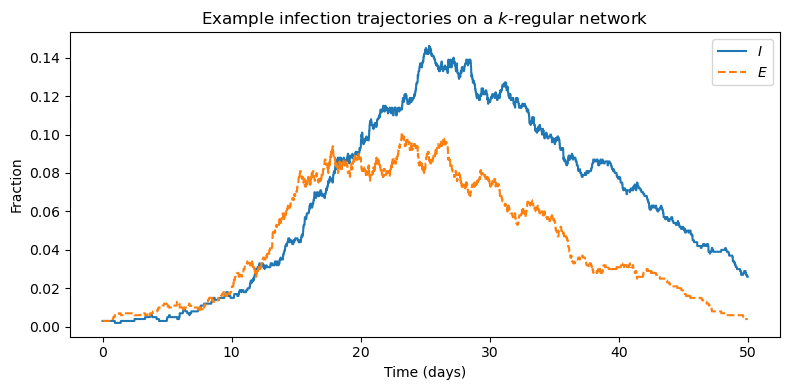

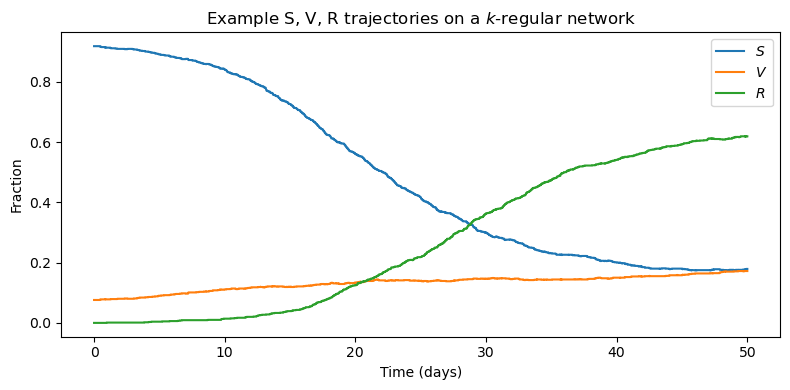

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ============================================
# Experiment 2: Discrete-time network simulation
# ============================================

# Global settings
N = 1000          # number of agents
k_deg = 10        # degree in k-regular graph
dt = 1e-2         # time step (days)
T_slots = 5000    # number of time slots (so T = T_slots * dt days)
R = 50            # number of replications (increase if desired)

rng = np.random.default_rng(seed=1234)

# Epidemiological parameters (same as Exp 1 baseline)
beta0 = 0.9
kappa_E = 0.33    # E->I
gamma = 0.20      # I->R
delta = 1.0 / 180 # waning of vaccine immunity
omega = 1.0 / 365 # waning of natural immunity
mu = 1e-4         # natural mortality (very small)
eta_E = 0.2       # mixing modifier for exposed

eps_s = 0.6       # vaccine efficacy vs infection (susceptibility)
eps_d = 0.6       # vaccine efficacy vs severity

# Behavioral / game parameters (strict regime)
alpha = 0.50      # strong behavioral sensitivity in beta(t)
sigma = 0.9       # high subsidy
rho = 1.0         # not used directly here (psi replaced by Fermi)
K_fermi = 0.5     # noise in Fermi rule

cV_baseline = 0.6 # baseline vaccination cost
C_I = 1.0         # infection cost intensity
b_baseline = 0.0  # baseline benefit

kappa_payoff = 0.10  # payoff learning rate for U_S, U_V (global)


# --------------------------------------------
# Payoff builder and behavioral couplings
# --------------------------------------------

def payoff_SV_network(E_frac, I_frac):
    """
    Payoffs for 'S-strategy' and 'V-strategy' agents
    (strict-regime payoff builder, similar to Exp 1).
    """
    risk = E_frac + I_frac
    cV_eff = cV_baseline - sigma

    pi_S = b_baseline - C_I * risk
    pi_V = b_baseline - cV_eff - C_I * (1.0 - eps_d) * risk
    return pi_S, pi_V


def update_beta_from_U(U_S, U_V):
    """
    beta(t) = beta0 * [1 - alpha * (U_V - U_S)], clamped to >=0.
    """
    delta_U = U_V - U_S
    beta_t = beta0 * (1.0 - alpha * delta_U)
    return max(0.0, beta_t)


def fermi_prob(delta_pi):
    """
    P(i <- j) = 1 / (1 + exp(-(pi_j - pi_i)/K_fermi)).
    Here delta_pi = pi_j - pi_i.
    """
    return 1.0 / (1.0 + np.exp(-delta_pi / K_fermi))


# --------------------------------------------
# Generate k-regular graph
# --------------------------------------------

G = nx.random_regular_graph(d=k_deg, n=N, seed=123)
neighbors = [list(G.neighbors(i)) for i in range(N)]


# --------------------------------------------
# Single replication of network experiment
# --------------------------------------------

def simulate_discrete_network():
    """
    Returns:
        time_grid: array
        xS, xV, xE, xI, xR: fractions over time
    """

    T = T_slots * dt
    time_grid = np.linspace(0.0, T, T_slots + 1)

    # Epidemiological states:
    # 0 = S, 1 = V, 2 = E, 3 = I, 4 = R
    state = np.zeros(N, dtype=int)

    # Initial small seed I and E, some vaccinated
    I0_frac = rng.uniform(1e-3, 3e-3)
    E0_frac = I0_frac
    V0_frac = rng.uniform(0.0, 0.2)

    nI0 = int(round(I0_frac * N))
    nE0 = int(round(E0_frac * N))
    nV0 = int(round(V0_frac * N))

    # Assign initial states
    all_idx = np.arange(N)
    rng.shuffle(all_idx)

    I_idx = all_idx[:nI0]
    E_idx = all_idx[nI0:nI0 + nE0]
    V_idx = all_idx[nI0 + nE0:nI0 + nE0 + nV0]
    S_idx = all_idx[nI0 + nE0 + nV0:]

    state[S_idx] = 0
    state[V_idx] = 1
    state[E_idx] = 2
    state[I_idx] = 3

    # Strategy: 0 = S-strategy, 1 = V-strategy
    # For simplicity, let strategy match initial epidemiological type:
    #   S and E and I and R keep a memory of "would vaccinate or not"
    strategy = np.zeros(N, dtype=int)
    strategy[V_idx] = 1  # vaccinated agents come from V-strategy
    # others remain 0 by default

    # Global payoff learning variables
    U_S = 0.0
    U_V = 0.0

    # Time series for fractions
    xS = np.zeros(T_slots + 1)
    xV = np.zeros(T_slots + 1)
    xE = np.zeros(T_slots + 1)
    xI = np.zeros(T_slots + 1)
    xR = np.zeros(T_slots + 1)

    def record(t_idx):
        S_count = np.sum(state == 0)
        V_count = np.sum(state == 1)
        E_count = np.sum(state == 2)
        I_count = np.sum(state == 3)
        R_count = np.sum(state == 4)
        total = S_count + V_count + E_count + I_count + R_count
        if total == 0:
            total = 1
        xS[t_idx] = S_count / total
        xV[t_idx] = V_count / total
        xE[t_idx] = E_count / total
        xI[t_idx] = I_count / total
        xR[t_idx] = R_count / total

    # Record t=0
    record(0)

    # Main loop over time slots
    for slot in range(1, T_slots + 1):
        # Global fractions for payoffs
        S_frac = xS[slot - 1]
        V_frac = xV[slot - 1]
        E_frac = xE[slot - 1]
        I_frac = xI[slot - 1]
        R_frac = xR[slot - 1]

        # Payoffs
        pi_S, pi_V = payoff_SV_network(E_frac, I_frac)

        # Update global payoff variables U_S, U_V
        U_bar = 0.5 * (U_S + U_V)
        U_S += dt * kappa_payoff * (pi_S - U_bar)
        U_V += dt * kappa_payoff * (pi_V - U_bar)

        # Behavioral coupling in beta(t)
        beta_t = update_beta_from_U(U_S, U_V)

        # --- Strategy update (Fermi imitation) ---
        i = rng.integers(0, N)
        if neighbors[i]:  # ensure at least one neighbor
            j = rng.choice(neighbors[i])
            # payoff of i depends on whether it is S-strategy or V-strategy
            # but we approximate with the global class payoffs:
            pi_i = pi_V if strategy[i] == 1 else pi_S
            pi_j = pi_V if strategy[j] == 1 else pi_S
            delta_pi = pi_j - pi_i
            p_imit = fermi_prob(delta_pi)
            if rng.random() < p_imit:
                strategy[i] = strategy[j]

        # --- Epidemiological transitions ---
        # We'll implement them in a vectorised way:

        # Force of infection from neighbors:
        # For each node, compute number of I and E neighbors and apply network FOI
        I_neighbors = np.zeros(N)
        E_neighbors = np.zeros(N)
        for u in range(N):
            neigh = neighbors[u]
            if len(neigh) == 0:
                continue
            neigh_states = state[neigh]
            I_neighbors[u] = np.sum(neigh_states == 3)
            E_neighbors[u] = np.sum(neigh_states == 2)

        # Effective lambda per node
        # Scale by degree k_deg so that if all neighbors are infectious, lambda ~ beta_t
        lambda_u = beta_t * (I_neighbors + eta_E * E_neighbors) / max(1, k_deg)

        # Transition probabilities per dt
        p_inf_S = 1.0 - np.exp(-lambda_u * dt)  # for S (strategy 0)
        p_inf_V = 1.0 - np.exp(-(1.0 - eps_s) * lambda_u * dt)  # for V-state

        p_EI = min(1.0, kappa_E * dt)
        p_IR = min(1.0, gamma * dt)
        p_VS = min(1.0, delta * dt)
        p_RS = min(1.0, omega * dt)
        p_mu = min(1.0, mu * dt)

        # Copy state to update
        new_state = state.copy()

        # S -> E infections
        S_mask = (state == 0)
        Vepidem_mask = (state == 1)
        # Infect S
        rand_S = rng.random(N)
        infect_S = (rand_S < p_inf_S) & S_mask
        new_state[infect_S] = 2  # E

        # Infect V (breakthrough)
        rand_V = rng.random(N)
        infect_V = (rand_V < p_inf_V) & Vepidem_mask
        new_state[infect_V] = 2  # E

        # Vaccination: S-strategy=1 agents in S state move to V with prob p_vac
        # We approximate the vaccination rate via a simple mapping from pi_V - pi_S:
        delta_pi_global = pi_V - pi_S
        p_vac = min(1.0, (1.0 / (1.0 + np.exp(-delta_pi_global / K_fermi))) * dt)
        S_strategy_mask = (strategy == 1) & (state == 0) & (~infect_S)
        rand_vac = rng.random(N)
        vaccinate = (rand_vac < p_vac) & S_strategy_mask
        new_state[vaccinate] = 1  # V

        # E -> I
        E_mask = (state == 2)
        rand_E = rng.random(N)
        prog_EI = (rand_E < p_EI) & E_mask
        new_state[prog_EI] = 3  # I

        # I -> R
        I_mask = (state == 3)
        rand_I = rng.random(N)
        prog_IR = (rand_I < p_IR) & I_mask
        new_state[prog_IR] = 4  # R

        # Waning V -> S
        V_mask = (state == 1) & (~infect_V)
        rand_VS = rng.random(N)
        waning_VS = (rand_VS < p_VS) & V_mask
        new_state[waning_VS] = 0  # S

        # Waning R -> S
        R_mask = (state == 4)
        rand_RS = rng.random(N)
        waning_RS = (rand_RS < p_RS) & R_mask
        new_state[waning_RS] = 0  # S

        # Natural mortality + rebirth into S
        rand_mu = rng.random(N)
        death_mask = (rand_mu < p_mu)
        # dead individuals are reborn instantly as S (to keep N constant)
        new_state[death_mask] = 0

        state = new_state

        # Record at this slot
        record(slot)

    return time_grid, xS, xV, xE, xI, xR


# --------------------------------------------
# Run Monte Carlo replications
# --------------------------------------------

if __name__ == "__main__":
    all_I_max = np.zeros(R)
    all_attack = np.zeros(R)
    all_VT = np.zeros(R)
    all_I_mean = np.zeros(R)

    example_time = None
    example_xS = None
    example_xV = None
    example_xE = None
    example_xI = None
    example_xR = None

    for r in range(R):
        print(f"Replication {r+1}/{R}...")
        tgrid, xS, xV, xE, xI, xR = simulate_discrete_network()

        if r == 0:
            example_time = tgrid
            example_xS = xS
            example_xV = xV
            example_xE = xE
            example_xI = xI
            example_xR = xR

        # Metrics
        I_max = np.max(xI)
        t_Imax = tgrid[np.argmax(xI)]
        attack_rate = xE[-1] + xI[-1] + xR[-1]
        V_T = xV[-1]
        I_mean = np.trapz(xI, tgrid) / tgrid[-1]

        all_I_max[r] = I_max
        all_attack[r] = attack_rate
        all_VT[r] = V_T
        all_I_mean[r] = I_mean

    # ---- Summary stats (mean + 95% CI) ----
    def mean_ci(x):
        x = np.asarray(x)
        m = np.mean(x)
        s = np.std(x, ddof=1)
        n = len(x)
        z = 1.96
        hw = z * s / np.sqrt(n)
        return m, m - hw, m + hw

    I_max_m, I_max_l, I_max_u = mean_ci(all_I_max)
    attack_m, attack_l, attack_u = mean_ci(all_attack)
    VT_m, VT_l, VT_u = mean_ci(all_VT)
    Imean_m, Imean_l, Imean_u = mean_ci(all_I_mean)

    def fmt(m, l, u, d=3):
        return f"{m:.{d}f} [{l:.{d}f}, {u:.{d}f}]"

    # ------------ LaTeX summary table -------------
    print("\n================ LaTeX Table: Discrete-time Network MC Summary ================\n")
    print(r"\begin{table}[H]")
    print(r"\centering")
    print(r"\small")
    print(r"\caption{Discrete-time network monte-carlo outcomes (means with 95\% confidence interval over $R=%d$ replications).}")
    print(r"\label{tab:dt_network_mc_summary}")
    print(r"\setlength{\tabcolsep}{5pt}")
    print(r"\renewcommand{\arraystretch}{1.2}")
    print(r"\begin{tabular}{@{}lcccc@{}}")
    print(r"\textbf{Metric} & Peak $I$ & Attack rate & $V(T)$ & $\overline{I}$ \\")
    print(r"\hline")
    print(r"Strict (network) & " +
          fmt(I_max_m, I_max_l, I_max_u, 3) + " & " +
          fmt(attack_m, attack_l, attack_u, 2) + " & " +
          fmt(VT_m, VT_l, VT_u, 2) + " & " +
          fmt(Imean_m, Imean_l, Imean_u, 3) + r" \\")
    print(r"\hline")
    print(r"\end{tabular}")
    print(r"\end{table}")
    print()

    # ------------ Plots: example trajectories -------------

    plt.figure(figsize=(8, 4))
    plt.plot(example_time, example_xI, label="$I$")
    plt.plot(example_time, example_xE, label="$E$", linestyle="--")
    plt.xlabel("Time (days)")
    plt.ylabel("Fraction")
    plt.title("Example infection trajectories on a $k$-regular network")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(example_time, example_xS, label="$S$")
    plt.plot(example_time, example_xV, label="$V$")
    plt.plot(example_time, example_xR, label="$R$")
    plt.xlabel("Time (days)")
    plt.ylabel("Fraction")
    plt.title("Example S, V, R trajectories on a $k$-regular network")
    plt.legend()
    plt.tight_layout()
    plt.show()
